# Modeling Evaluation
- The mean and standardeviation of 100 times Errors in Random random sampling
- The mean and standardeviation of 100 times Errors in SMOTE oversampling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [39]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

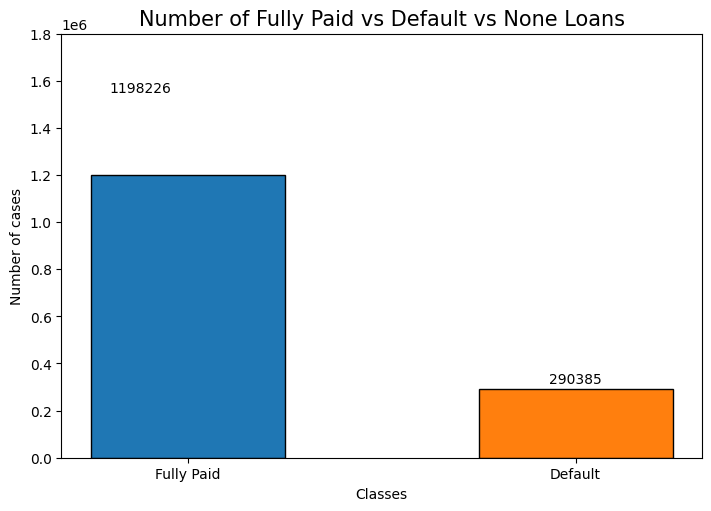

In [40]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [41]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.126335726707647


## Base Model

In [42]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [43]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

In [44]:
def Modeling(X_train, X_val, X_test, y_train, y_val, y_test):
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    evals_result = model.evals_result()
    train_loss = evals_result['validation_0']['logloss']
    val_loss = evals_result['validation_1']['logloss']

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)

    precision_0 = report['0']['precision']
    precision_1 = report['1']['precision']
    recall_0 = report['0']['recall']
    recall_1 = report['1']['recall']

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_roc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    auc_prc = auc(recall_curve, precision_curve)

    ## Train, val loss는 데이터의 분포의 차이를 볼 수 있다. 따라서 mean값으로 함함
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    return precision_0, precision_1, recall_0, recall_1, mean_train_loss, mean_val_loss, auc_roc, auc_prc

def eval_base(data_x, data_y, X_test, y_test):
    confusion_0_precision = []
    confusion_1_precision = []
    confusion_0_recall = []
    confusion_1_recall = []
    all_train_loss = []
    all_val_loss = []
    all_roc = []
    all_prc = []

    for i in tqdm(range(100), desc="Base Iteration"):
        x = data_x
        y = data_y

        X_train, X_val, y_train, y_val = train_test_split(
            x, y, test_size=0.20, random_state=np.random.randint(0, 10000), stratify=y)

        p0, p1, r0, r1, t_loss, v_loss, roc, prc = Modeling(
            X_train, X_val, X_test, y_train, y_val, y_test)

        confusion_0_precision.append(p0)
        confusion_1_precision.append(p1)
        confusion_0_recall.append(r0)
        confusion_1_recall.append(r1)
        all_train_loss.append(t_loss)
        all_val_loss.append(v_loss)
        all_roc.append(roc)
        all_prc.append(prc)

    results = {
        'precision_0_mean': np.mean(confusion_0_precision),
        'precision_0_std': np.std(confusion_0_precision),
        'precision_1_mean': np.mean(confusion_1_precision),
        'precision_1_std': np.std(confusion_1_precision),
        'recall_0_mean': np.mean(confusion_0_recall),
        'recall_0_std': np.std(confusion_0_recall),
        'recall_1_mean': np.mean(confusion_1_recall),
        'recall_1_std': np.std(confusion_1_recall),
        'train_loss_mean': np.mean(all_train_loss),
        'train_loss_std': np.std(all_train_loss),
        'val_loss_mean': np.mean(all_val_loss),
        'val_loss_std': np.std(all_val_loss),
        'auc_roc_mean': np.mean(all_roc),
        'auc_roc_std': np.std(all_roc),
        'auc_prc_mean': np.mean(all_prc),
        'auc_prc_std': np.std(all_prc),
    }

    return results

In [45]:
results = eval_base(data_x, data_y, X_test, y_test)

Base Iteration: 100%|██████████| 100/100 [1:05:25<00:00, 39.26s/it]


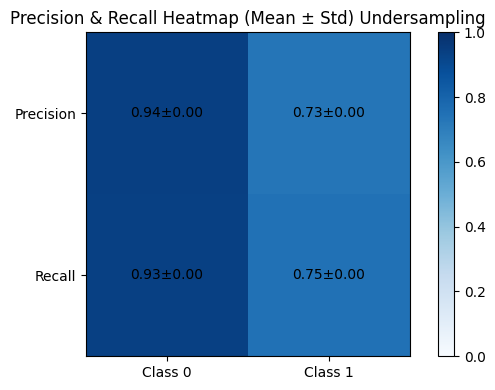

In [46]:
# 1. Precision/Recall confusion-matrix-like heatmap
metrics = ['Precision', 'Recall']
classes = ['Class 0', 'Class 1']
means = np.array([
    [results['precision_0_mean'], results['precision_1_mean']],
    [results['recall_0_mean'], results['recall_1_mean']]
])
stds = np.array([
    [results['precision_0_std'], results['precision_1_std']],
    [results['recall_0_std'], results['recall_1_std']]
])

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(means, cmap="Blues", vmin=0, vmax=1)

# Add text annotations
for i in range(len(metrics)):
    for j in range(len(classes)):
        text = f"{means[i, j]:.2f}±{stds[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center", color="black", fontsize=10)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(metrics)))
ax.set_xticklabels(classes)
ax.set_yticklabels(metrics)
plt.title("Precision & Recall Heatmap (Mean ± Std) Undersampling")
plt.colorbar(im)
plt.tight_layout()
plt.show()

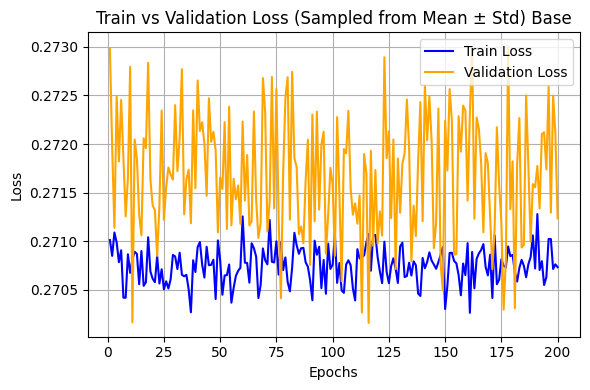

In [47]:
# 2. Train/Val Loss Plot
plt.figure(figsize=(6, 4))
epochs = np.arange(1, 201)
train_loss = np.random.normal(results['train_loss_mean'], results['train_loss_std'], size=200)
val_loss = np.random.normal(results['val_loss_mean'], results['val_loss_std'], size=200)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Sampled from Mean ± Std) Base")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

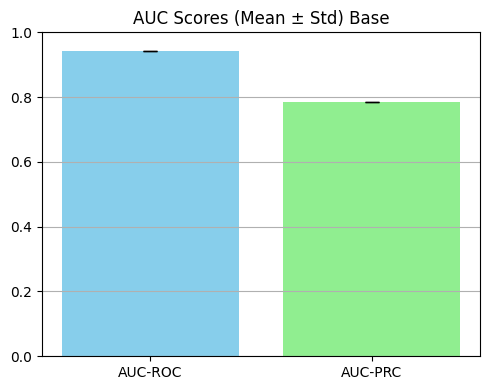

In [48]:
# 3. AUC ROC & PRC Bar Chart
plt.figure(figsize=(5, 4))
auc_scores = [results['auc_roc_mean'], results['auc_prc_mean']]
auc_stds = [results['auc_roc_std'], results['auc_prc_std']]
labels = ['AUC-ROC', 'AUC-PRC']
plt.bar(labels, auc_scores, yerr=auc_stds, capsize=5, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.title("AUC Scores (Mean ± Std) Base")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Random Undersampling

In [49]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [50]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [51]:
def Modeling(X_train, X_val, X_test, y_train, y_val, y_test):
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    evals_result = model.evals_result()
    train_loss = evals_result['validation_0']['logloss']
    val_loss = evals_result['validation_1']['logloss']

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)

    precision_0 = report['0']['precision']
    precision_1 = report['1']['precision']
    recall_0 = report['0']['recall']
    recall_1 = report['1']['recall']

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_roc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    auc_prc = auc(recall_curve, precision_curve)

    ## Train, val loss는 데이터의 분포의 차이를 볼 수 있다. 따라서 mean값으로 함함
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    return precision_0, precision_1, recall_0, recall_1, mean_train_loss, mean_val_loss, auc_roc, auc_prc

def eval_undersample(data_x, data_y, X_test, y_test):
    confusion_0_precision = []
    confusion_1_precision = []
    confusion_0_recall = []
    confusion_1_recall = []
    all_train_loss = []
    all_val_loss = []
    all_roc = []
    all_prc = []

    for i in tqdm(range(100), desc="Undersample Iteration"):
        x = data_x
        y = data_y
        undersampler = RandomUnderSampler()
        X_under, y_under = undersampler.fit_resample(x, y)

        data_under = pd.concat([
            pd.DataFrame(X_under, columns=x.columns),
            pd.DataFrame(y_under, columns=['loan_status'])
        ], axis=1)

        x = data_under.drop(columns=['loan_status'])
        y = data_under[['loan_status']]

        X_train, X_val, y_train, y_val = train_test_split(
            x, y, test_size=0.20, random_state=np.random.randint(0, 10000), stratify=y)

        p0, p1, r0, r1, t_loss, v_loss, roc, prc = Modeling(
            X_train, X_val, X_test, y_train, y_val, y_test)

        confusion_0_precision.append(p0)
        confusion_1_precision.append(p1)
        confusion_0_recall.append(r0)
        confusion_1_recall.append(r1)
        all_train_loss.append(t_loss)
        all_val_loss.append(v_loss)
        all_roc.append(roc)
        all_prc.append(prc)

    results = {
        'precision_0_mean': np.mean(confusion_0_precision),
        'precision_0_std': np.std(confusion_0_precision),
        'precision_1_mean': np.mean(confusion_1_precision),
        'precision_1_std': np.std(confusion_1_precision),
        'recall_0_mean': np.mean(confusion_0_recall),
        'recall_0_std': np.std(confusion_0_recall),
        'recall_1_mean': np.mean(confusion_1_recall),
        'recall_1_std': np.std(confusion_1_recall),
        'train_loss_mean': np.mean(all_train_loss),
        'train_loss_std': np.std(all_train_loss),
        'val_loss_mean': np.mean(all_val_loss),
        'val_loss_std': np.std(all_val_loss),
        'auc_roc_mean': np.mean(all_roc),
        'auc_roc_std': np.std(all_roc),
        'auc_prc_mean': np.mean(all_prc),
        'auc_prc_std': np.std(all_prc),
    }

    return results

In [52]:
results = eval_undersample(data_x, data_y, X_test, y_test)

Undersample Iteration: 100%|██████████| 100/100 [26:16<00:00, 15.77s/it]


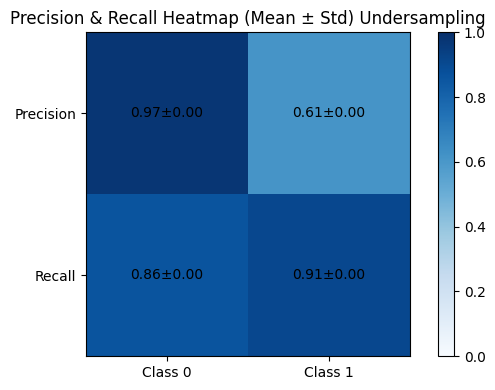

In [53]:
# 1. Precision/Recall confusion-matrix-like heatmap
metrics = ['Precision', 'Recall']
classes = ['Class 0', 'Class 1']
means = np.array([
    [results['precision_0_mean'], results['precision_1_mean']],
    [results['recall_0_mean'], results['recall_1_mean']]
])
stds = np.array([
    [results['precision_0_std'], results['precision_1_std']],
    [results['recall_0_std'], results['recall_1_std']]
])

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(means, cmap="Blues", vmin=0, vmax=1)

# Add text annotations
for i in range(len(metrics)):
    for j in range(len(classes)):
        text = f"{means[i, j]:.2f}±{stds[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center", color="black", fontsize=10)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(metrics)))
ax.set_xticklabels(classes)
ax.set_yticklabels(metrics)
plt.title("Precision & Recall Heatmap (Mean ± Std) Undersampling")
plt.colorbar(im)
plt.tight_layout()
plt.show()

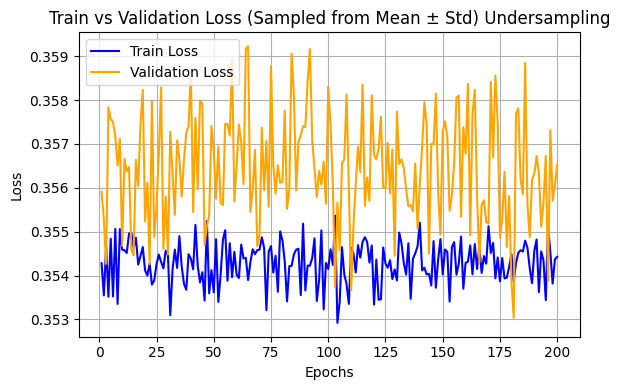

In [54]:
# 2. Train/Val Loss Plot
plt.figure(figsize=(6, 4))
epochs = np.arange(1, 201)
train_loss = np.random.normal(results['train_loss_mean'], results['train_loss_std'], size=200)
val_loss = np.random.normal(results['val_loss_mean'], results['val_loss_std'], size=200)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Sampled from Mean ± Std) Undersampling")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

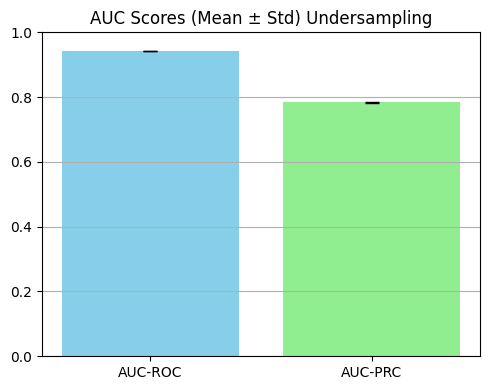

In [55]:
# 3. AUC ROC & PRC Bar Chart
plt.figure(figsize=(5, 4))
auc_scores = [results['auc_roc_mean'], results['auc_prc_mean']]
auc_stds = [results['auc_roc_std'], results['auc_prc_std']]
labels = ['AUC-ROC', 'AUC-PRC']
plt.bar(labels, auc_scores, yerr=auc_stds, capsize=5, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.title("AUC Scores (Mean ± Std) Undersampling")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## SMOTE-Oversampling

In [56]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [57]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [58]:
def Modeling(X_train, X_val, X_test, y_train, y_val, y_test):
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    evals_result = model.evals_result()
    train_loss = evals_result['validation_0']['logloss']
    val_loss = evals_result['validation_1']['logloss']

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)

    precision_0 = report['0']['precision']
    precision_1 = report['1']['precision']
    recall_0 = report['0']['recall']
    recall_1 = report['1']['recall']

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_roc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    auc_prc = auc(recall_curve, precision_curve)

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    return precision_0, precision_1, recall_0, recall_1, mean_train_loss, mean_val_loss, auc_roc, auc_prc

def eval_oversampling(data_x, data_y, X_test, y_test):
    confusion_0_precision = []
    confusion_1_precision = []
    confusion_0_recall = []
    confusion_1_recall = []
    all_train_loss = []
    all_val_loss = []
    all_roc = []
    all_prc = []

    for i in tqdm(range(100), desc="SMOTE Iteration"):
        x = data_x
        y = data_y

        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(x, y)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)

        x = augmentation_data.drop(columns=['loan_status'])
        y = augmentation_data[['loan_status']]

        X_train, X_val, y_train, y_val = train_test_split(
            x, y, test_size=0.20, random_state=np.random.randint(0, 10000), stratify=y)

        p0, p1, r0, r1, t_loss, v_loss, roc, prc = Modeling(
            X_train, X_val, X_test, y_train, y_val, y_test)

        confusion_0_precision.append(p0)
        confusion_1_precision.append(p1)
        confusion_0_recall.append(r0)
        confusion_1_recall.append(r1)
        all_train_loss.append(t_loss)
        all_val_loss.append(v_loss)
        all_roc.append(roc)
        all_prc.append(prc)

    results = {
        'precision_0_mean': np.mean(confusion_0_precision),
        'precision_0_std': np.std(confusion_0_precision),
        'precision_1_mean': np.mean(confusion_1_precision),
        'precision_1_std': np.std(confusion_1_precision),
        'recall_0_mean': np.mean(confusion_0_recall),
        'recall_0_std': np.std(confusion_0_recall),
        'recall_1_mean': np.mean(confusion_1_recall),
        'recall_1_std': np.std(confusion_1_recall),
        'train_loss_mean': np.mean(all_train_loss),
        'train_loss_std': np.std(all_train_loss),
        'val_loss_mean': np.mean(all_val_loss),
        'val_loss_std': np.std(all_val_loss),
        'auc_roc_mean': np.mean(all_roc),
        'auc_roc_std': np.std(all_roc),
        'auc_prc_mean': np.mean(all_prc),
        'auc_prc_std': np.std(all_prc),
    }

    return results

In [59]:
results = eval_oversampling(data_x, data_y, X_test, y_test)

SMOTE Iteration: 100%|██████████| 100/100 [2:01:11<00:00, 72.71s/it] 


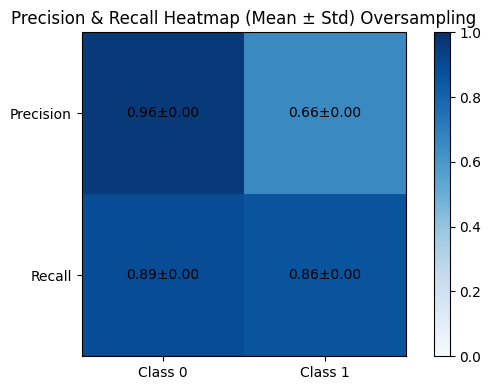

In [60]:
# 1. Precision/Recall confusion-matrix-like heatmap
metrics = ['Precision', 'Recall']
classes = ['Class 0', 'Class 1']
means = np.array([
    [results['precision_0_mean'], results['precision_1_mean']],
    [results['recall_0_mean'], results['recall_1_mean']]
])
stds = np.array([
    [results['precision_0_std'], results['precision_1_std']],
    [results['recall_0_std'], results['recall_1_std']]
])

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(means, cmap="Blues", vmin=0, vmax=1)

# Add text annotations
for i in range(len(metrics)):
    for j in range(len(classes)):
        text = f"{means[i, j]:.2f}±{stds[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center", color="black", fontsize=10)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(metrics)))
ax.set_xticklabels(classes)
ax.set_yticklabels(metrics)
plt.title("Precision & Recall Heatmap (Mean ± Std) Oversampling")
plt.colorbar(im)
plt.tight_layout()
plt.show()

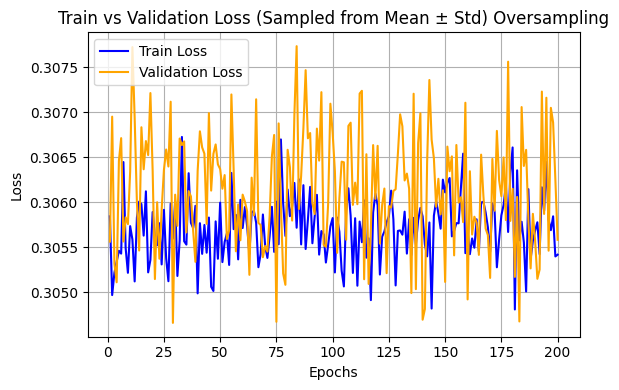

In [61]:
# 2. Train/Val Loss Plot
plt.figure(figsize=(6, 4))
epochs = np.arange(1, 201)
train_loss = np.random.normal(results['train_loss_mean'], results['train_loss_std'], size=200)
val_loss = np.random.normal(results['val_loss_mean'], results['val_loss_std'], size=200)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Sampled from Mean ± Std) Oversampling")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

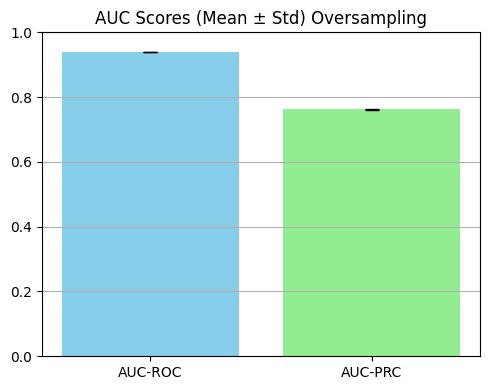

In [62]:
# 3. AUC ROC & PRC Bar Chart
plt.figure(figsize=(5, 4))
auc_scores = [results['auc_roc_mean'], results['auc_prc_mean']]
auc_stds = [results['auc_roc_std'], results['auc_prc_std']]
labels = ['AUC-ROC', 'AUC-PRC']
plt.bar(labels, auc_scores, yerr=auc_stds, capsize=5, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.title("AUC Scores (Mean ± Std) Oversampling")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Table-GAN

In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [4]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [5]:
def Modeling(X_train, X_val, X_test, y_train, y_val, y_test):
    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    evals_result = model.evals_result()
    train_loss = evals_result['validation_0']['logloss']
    val_loss = evals_result['validation_1']['logloss']

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)

    precision_0 = report['0']['precision']
    precision_1 = report['1']['precision']
    recall_0 = report['0']['recall']
    recall_1 = report['1']['recall']

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_roc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    auc_prc = auc(recall_curve, precision_curve)

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    return precision_0, precision_1, recall_0, recall_1, mean_train_loss, mean_val_loss, auc_roc, auc_prc

def eval_tablegan(data_x, data_y, X_test, y_test):
    confusion_0_precision = []
    confusion_1_precision = []
    confusion_0_recall = []
    confusion_1_recall = []
    all_train_loss = []
    all_val_loss = []
    all_roc = []
    all_prc = []

    fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
    fake = pd.read_csv(fake_path)
    fake['loan_status'] = 1

    for i in tqdm(range(100), desc="Tabla-GAN Iteration"):
        x = data_x
        y = data_y

        X_train, X_val, y_train, y_val = train_test_split(
            x, y, test_size=0.20, random_state=np.random.randint(0, 10000), stratify=y)
        
        train_dataset = pd.concat([X_train, y_train], axis=1)
        train_total = pd.concat([train_dataset,fake])
        train_total = shuffle(train_total, random_state=np.random.randint(0, 10000))

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        p0, p1, r0, r1, t_loss, v_loss, roc, prc = Modeling(
            X_train, X_val, X_test, y_train, y_val, y_test)

        confusion_0_precision.append(p0)
        confusion_1_precision.append(p1)
        confusion_0_recall.append(r0)
        confusion_1_recall.append(r1)
        all_train_loss.append(t_loss)
        all_val_loss.append(v_loss)
        all_roc.append(roc)
        all_prc.append(prc)

    results = {
        'precision_0_mean': np.mean(confusion_0_precision),
        'precision_0_std': np.std(confusion_0_precision),
        'precision_1_mean': np.mean(confusion_1_precision),
        'precision_1_std': np.std(confusion_1_precision),
        'recall_0_mean': np.mean(confusion_0_recall),
        'recall_0_std': np.std(confusion_0_recall),
        'recall_1_mean': np.mean(confusion_1_recall),
        'recall_1_std': np.std(confusion_1_recall),
        'train_loss_mean': np.mean(all_train_loss),
        'train_loss_std': np.std(all_train_loss),
        'val_loss_mean': np.mean(all_val_loss),
        'val_loss_std': np.std(all_val_loss),
        'auc_roc_mean': np.mean(all_roc),
        'auc_roc_std': np.std(all_roc),
        'auc_prc_mean': np.mean(all_prc),
        'auc_prc_std': np.std(all_prc),
    }

    return results

In [ ]:
results = eval_tablegan(data_x, data_y, X_test, y_test)

Tabla-GAN Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# 1. Precision/Recall confusion-matrix-like heatmap
metrics = ['Precision', 'Recall']
classes = ['Class 0', 'Class 1']
means = np.array([
    [results['precision_0_mean'], results['precision_1_mean']],
    [results['recall_0_mean'], results['recall_1_mean']]
])
stds = np.array([
    [results['precision_0_std'], results['precision_1_std']],
    [results['recall_0_std'], results['recall_1_std']]
])

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(means, cmap="Blues", vmin=0, vmax=1)

# Add text annotations
for i in range(len(metrics)):
    for j in range(len(classes)):
        text = f"{means[i, j]:.2f}±{stds[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center", color="black", fontsize=10)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(metrics)))
ax.set_xticklabels(classes)
ax.set_yticklabels(metrics)
plt.title("Precision & Recall Heatmap (Mean ± Std) Table-GAN")
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [ ]:
# 2. Train/Val Loss Plot
plt.figure(figsize=(6, 4))
epochs = np.arange(1, 201)
train_loss = np.random.normal(results['train_loss_mean'], results['train_loss_std'], size=200)
val_loss = np.random.normal(results['val_loss_mean'], results['val_loss_std'], size=200)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Sampled from Mean ± Std) Table-GAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 3. AUC ROC & PRC Bar Chart
plt.figure(figsize=(5, 4))
auc_scores = [results['auc_roc_mean'], results['auc_prc_mean']]
auc_stds = [results['auc_roc_std'], results['auc_prc_std']]
labels = ['AUC-ROC', 'AUC-PRC']
plt.bar(labels, auc_scores, yerr=auc_stds, capsize=5, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.title("AUC Scores (Mean ± Std) Table-GAN")
plt.grid(axis='y')
plt.tight_layout()
plt.show()